In [5]:
%matplotlib qt

# Magnetic moment and Energy calculator

Caculates the magnetic moment and energy table used in the LiHoF_4 simulation.
Includes procedures to:
* plot slices of the functions
* fit polynomials to the functions (turned out to be a dead end)

In [6]:
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
from scipy import optimize
import math
import pandas as pd
import sys
import os

In [7]:
#constants
hbar=1
D=0.294
E=0.046
u_B=0.6717
g_L=2
J=10
deg_J = 2 * J + 1

In [8]:
# J matrices
jplus = hbar * np.diag(np.array( [ math.sqrt(J*(J+1) - m*(m+1)) for m in np.arange(-J,J) ] ), 1)
jminus = hbar * np.diag(np.array( [ math.sqrt(J*(J+1) - m*(m-1)) for m in np.arange(-J+1,J+1) ] ),-1)
jx = (jplus + jminus) * 0.5
jy = (jplus - jminus) * (-0.5j)
jz = hbar * np.diag(np.arange(-J,J+1))
I_J = np.diag(np.ones(int(round(deg_J))))

# crystal field Hamiltonian
H_cf = -D*LA.matrix_power(jz,2) + E*(LA.matrix_power(jx,2)-LA.matrix_power(jy,2))

In [9]:
meanBx=0.0
maxBx=3.0       # the real max is one less than this
maxBz=1.2       # the real max is one less than this
number=40       # the real number is twice this
min_bz=0.0014
# next:
#min_bz=0.00967
Bx = np.geomspace(1,maxBx,num=number) - 1 + np.geomspace(1,maxBx,num=number)[1]- np.geomspace(1,maxBx,num=number)[0]
# Bx = np.concatenate((np.flip(-1*Bx),[0.0],Bx),axis=0)
Bx = np.concatenate((np.flip(-1*Bx),Bx),axis=0)
Bx += meanBx
By = np.geomspace(1,maxBx,num=number) - 1 + np.geomspace(1,maxBx,num=number)[1] - np.geomspace(1,maxBx,num=number)[0]
# By = np.concatenate((np.flip(-1*By),[0.0],By),axis=0)
By = np.concatenate((np.flip(-1*By),By),axis=0)
# Bz = np.geomspace(1,maxBz,num=number) - 1 + np.geomspace(1,maxBz,num=number)[1] - np.geomspace(1,maxBz,num=number)[0]
Bz = np.geomspace(1,maxBz,num=number) - 1 + min_bz
# Bz = np.concatenate((np.flip(-1*Bz),[0.0],Bz),axis=0)
Bz = np.concatenate((np.flip(-1*Bz),Bz),axis=0)

In [10]:
# Create full standard table
res_energy_up=[]
res_energy_down=[]
res_magnetic_moment_up=[]
res_magnetic_moment_down=[]
for i, bz in enumerate(Bz):
    res_energy_y_up=[]
    res_energy_y_down=[]
    res_magnetic_moment_y_up=[]
    res_magnetic_moment_y_down=[]
    for by in By:
        res_energy_x_up=[]
        res_energy_x_down=[]
        res_magnetic_moment_x_up=[]
        res_magnetic_moment_x_down=[]
        for bx in Bx:
            H_zeeman = u_B*g_L*(bx*jx + by*jy + bz*jz)    # zeeman term
            H = H_cf - H_zeeman                 # full hamiltonian
            w,v = LA.eigh(H)

            # initially assume lower level is up and upper is down
            energy_up = w[0]
            energy_down = w[1]
            magnetic_moment_up = np.real(np.diagonal(np.conj(v.T)@jz@v)[0])
            magnetic_moment_down = np.real(np.diagonal(np.conj(v.T)@jz@v)[1])
            j=0
            if np.allclose(w[j],w[j:j+2],atol=10**-15):
                # rotate
                change_of_basis_matrix_inverse=np.transpose(v.T)
                change_of_basis_matrix=LA.inv(change_of_basis_matrix_inverse)
                new_jz=change_of_basis_matrix @ jz @ change_of_basis_matrix_inverse
                j=0
                magnetic_moments = LA.eigvalsh(new_jz[j:j+2,j:j+2])
                magnetic_moment_up = np.real(magnetic_moments[0])
                magnetic_moment_down = np.real(magnetic_moments[1])
                print("all close!")
            
            if (magnetic_moment_up < magnetic_moment_down):
                    # switch moments
                    temp = magnetic_moment_up
                    magnetic_moment_up = magnetic_moment_down
                    magnetic_moment_down = temp
                    # switch energies
                    temp = energy_up
                    energy_up = energy_down
                    energy_down = temp

            res_energy_x_up.append(energy_up)
            res_energy_x_down.append(energy_down)

            res_magnetic_moment_x_up.append(magnetic_moment_up)
            res_magnetic_moment_x_down.append(magnetic_moment_down)
        res_energy_y_up.append(res_energy_x_up)
        res_energy_y_down.append(res_energy_x_down)
        res_magnetic_moment_y_up.append(res_magnetic_moment_x_up)
        res_magnetic_moment_y_down.append(res_magnetic_moment_x_down)
    res_energy_up.append(res_energy_y_up)
    res_energy_down.append(res_energy_y_down)
    res_magnetic_moment_up.append(res_magnetic_moment_y_up)
    res_magnetic_moment_down.append(res_magnetic_moment_y_down)
    print(str(100*i/Bz.size) + "%")

energy_up_arr_full = np.array(res_energy_up)
energy_down_arr_full = np.array(res_energy_down)
magnetic_moment_up_arr_full = np.array(res_magnetic_moment_up)
magnetic_moment_down_arr_full = np.array(res_magnetic_moment_down)
print("check up and down magnetic moment arrays are the same: " + str(np.allclose((-1)*(np.flip(magnetic_moment_down_arr_full, 0)), magnetic_moment_up_arr_full, atol=1e-15)))
print("check up and down energy arrays are the same: " + str(np.allclose(np.flip(energy_down_arr_full, 0), energy_up_arr_full, atol=1e-15)))

0.0%
1.25%
2.5%
3.75%
5.0%
6.25%
7.5%
8.75%
10.0%
11.25%
12.5%
13.75%
15.0%
16.25%
17.5%
18.75%
20.0%
21.25%
22.5%
23.75%
25.0%
26.25%
27.5%
28.75%
30.0%
31.25%
32.5%
33.75%
35.0%
36.25%
37.5%
38.75%
40.0%
41.25%
42.5%
43.75%
45.0%
46.25%
47.5%
48.75%
50.0%
51.25%
52.5%
53.75%
55.0%
56.25%
57.5%
58.75%
60.0%
61.25%
62.5%
63.75%
65.0%
66.25%
67.5%
68.75%
70.0%
71.25%
72.5%
73.75%
75.0%
76.25%
77.5%
78.75%
80.0%
81.25%
82.5%
83.75%
85.0%
86.25%
87.5%
88.75%
90.0%
91.25%
92.5%
93.75%
95.0%
96.25%
97.5%
98.75%
check up and down magnetic moment arrays are the same: True
check up and down energy arrays are the same: True


In [11]:
energy_up_arr = energy_up_arr_full
energy_down_arr = energy_down_arr_full
magnetic_moment_up_arr = magnetic_moment_up_arr_full
magnetic_moment_down_arr = magnetic_moment_down_arr_full

In [9]:
# Create full table with constant B_z = +-0.3

res_energy_up=[]
res_energy_down=[]
res_magnetic_moment_up=[]
res_magnetic_moment_down=[]
for i, bz in enumerate(Bz):
    res_energy_y_up=[]
    res_energy_y_down=[]
    res_magnetic_moment_y_up=[]
    res_magnetic_moment_y_down=[]
    for by in By:
        res_energy_x_up=[]
        res_energy_x_down=[]
        res_magnetic_moment_x_up=[]
        res_magnetic_moment_x_down=[]
        for bx in Bx:
            H_zeeman = u_B*g_L*(bx*jx + by*jy + bz*jz)    # zeeman term
            H = H_cf - H_zeeman                 # full hamiltonian
            w,v = LA.eigh(H)
            # initially assume lower level is up and upper is down
            energy_up = w[0]
            energy_down = w[1]
            
            if bz<0:
                # switch energies
                temp = energy_up
                energy_up = energy_down
                energy_down = temp
            effective_bz = 1.1*max(abs(bx),abs(by))
            H_zeeman = u_B*g_L*(bx*jx + by*jy + effective_bz*jz)    # zeeman term
            H = H_cf - H_zeeman                 # full hamiltonian
            w,v = LA.eigh(H)
            
            # rotate
            change_of_basis_matrix_inverse=np.transpose(v.T)
            change_of_basis_matrix=LA.inv(change_of_basis_matrix_inverse)
            new_jz=change_of_basis_matrix @ jz @ change_of_basis_matrix_inverse
            if np.allclose(w[0],w[1],atol=10**-10):
                new_jz[0:2,0:2]=np.diag(LA.eigvalsh(new_jz[0:2,0:2]))
            
#             magnetic_moment_up = np.real(np.diagonal(np.conj(v.T)@jz@v)[0])
            magnetic_moment_up = new_jz[0,0]
    
            H_zeeman = u_B*g_L*(bx*jx + by*jy + -effective_bz*jz)    # zeeman term
            H = H_cf - H_zeeman                 # full hamiltonian
            w,v = LA.eigh(H)
            
            # rotate
            change_of_basis_matrix_inverse=np.transpose(v.T)
            change_of_basis_matrix=LA.inv(change_of_basis_matrix_inverse)
            new_jz=change_of_basis_matrix @ jz @ change_of_basis_matrix_inverse
            if np.allclose(w[0],w[1],atol=10**-10):
                new_jz[0:2,0:2]=np.diag(LA.eigvalsh(new_jz[0:2,0:2]))
            
#             magnetic_moment_down = np.real(np.diagonal(np.conj(v.T)@jz@v)[0])
            magnetic_moment_down = new_jz[0,0]
    
            # code to 

            if (magnetic_moment_up < magnetic_moment_down):
                    # switch moments
                    temp = magnetic_moment_up
                    magnetic_moment_up = magnetic_moment_down
                    magnetic_moment_down = temp
                    # switch energies
                    temp = energy_up
                    energy_up = energy_down
                    energy_down = temp
            
            res_energy_x_up.append(energy_up)
            res_energy_x_down.append(energy_down)

            res_magnetic_moment_x_up.append(magnetic_moment_up)
            res_magnetic_moment_x_down.append(magnetic_moment_down)
        res_energy_y_up.append(res_energy_x_up)
        res_energy_y_down.append(res_energy_x_down)
        res_magnetic_moment_y_up.append(res_magnetic_moment_x_up)
        res_magnetic_moment_y_down.append(res_magnetic_moment_x_down)
    res_energy_up.append(res_energy_y_up)
    res_energy_down.append(res_energy_y_down)
    res_magnetic_moment_up.append(res_magnetic_moment_y_up)
    res_magnetic_moment_down.append(res_magnetic_moment_y_down)
    print(str(100*i/Bz.size) + "%")

energy_up_arr = np.array(res_energy_up)
energy_down_arr = np.array(res_energy_down)
magnetic_moment_up_arr = np.array(res_magnetic_moment_up)
magnetic_moment_down_arr = np.array(res_magnetic_moment_down)
print("check up and down magnetic moment arrays are the same: " + str(np.allclose((-1)*(np.flip(magnetic_moment_down_arr, 0)), magnetic_moment_up_arr, atol=1e-15)))
print("check up and down energy arrays are the same: " + str(np.allclose(np.flip(energy_down_arr, 0), energy_up_arr, atol=1e-15)))

0.0%
1.2345679012345678%
2.4691358024691357%
3.7037037037037037%
4.938271604938271%
6.172839506172839%
7.407407407407407%
8.641975308641975%
9.876543209876543%
11.11111111111111%
12.345679012345679%
13.580246913580247%
14.814814814814815%
16.049382716049383%
17.28395061728395%
18.51851851851852%
19.753086419753085%
20.987654320987655%
22.22222222222222%
23.45679012345679%
24.691358024691358%
25.925925925925927%
27.160493827160494%
28.395061728395063%
29.62962962962963%
30.864197530864196%
32.098765432098766%
33.333333333333336%
34.5679012345679%
35.80246913580247%
37.03703703703704%
38.27160493827161%
39.50617283950617%
40.74074074074074%
41.97530864197531%
43.20987654320987%
44.44444444444444%
45.67901234567901%
46.91358024691358%
48.148148148148145%
49.382716049382715%
50.617283950617285%
51.851851851851855%
53.08641975308642%
54.32098765432099%
55.55555555555556%
56.79012345679013%
58.02469135802469%
59.25925925925926%
60.49382716049383%
61.72839506172839%
62.96296296296296%
64.1975

## Plot slices of magnetic moment vs. $B_z$

In [15]:
# function to create a slice of the moment & energy functions where bx, by are constants and Bz is an array
# returns exact results in format: (magnetic_moment_up_arr, magnetic_moment_down_arr, energy_up_arr, energy_down_arr)
def create_slice_exact_diag(bx, by, Bz):
    res_energy_up=[]
    res_energy_down=[]
    res_magnetic_moment_up=[]
    res_magnetic_moment_down=[]
    for i, bz in enumerate(Bz):
        H_zeeman = u_B*g_L*(bx*jx + by*jy + bz*jz)    # zeeman term
        H = H_cf - H_zeeman                 # full hamiltonian
        w,v = LA.eigh(H)
        # initially assume lower level is up and upper is down
        energy_up = w[0]
        energy_down = w[1]
        magnetic_moment_up = np.real(np.diagonal(np.conj(v.T)@jz@v)[0])
        magnetic_moment_down = np.real(np.diagonal(np.conj(v.T)@jz@v)[1])

        if (magnetic_moment_up < magnetic_moment_down):
            # switch moments
            temp = magnetic_moment_up
            magnetic_moment_up = magnetic_moment_down
            magnetic_moment_down = temp
            # switch energies
            temp = energy_up
            energy_up = energy_down
            energy_down = temp

        res_energy_up.append(energy_up)
        res_energy_down.append(energy_down)

        res_magnetic_moment_up.append(magnetic_moment_up)
        res_magnetic_moment_down.append(magnetic_moment_down)
        
        #print(str(100*i/Bz.size) + "%")

    energy_up_arr = np.array(res_energy_up)
    energy_down_arr = np.array(res_energy_down)
    magnetic_moment_up_arr = np.array(res_magnetic_moment_up)
    magnetic_moment_down_arr = np.array(res_magnetic_moment_down)
    return (magnetic_moment_up_arr, magnetic_moment_down_arr, energy_up_arr, energy_down_arr)

In [16]:
plt.figure(figsize=(12,4))

<Figure size 864x288 with 0 Axes>

<Figure size 864x288 with 0 Axes>

C:\WPy64-3770\python-3.7.7.amd64\lib\site-packages\ipykernel_launcher.py:64: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


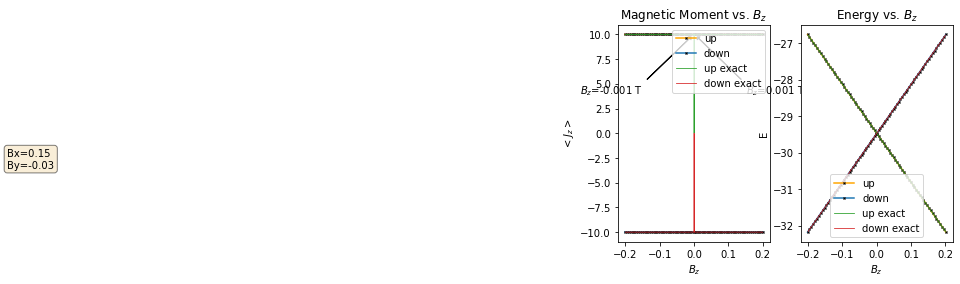

In [17]:
# find the indices of the Bx and By values closest to 1.0 and 0.0
BxIndex=(np.abs(np.array(Bx) - 0.15)).argmin()
ByIndex=(np.abs(np.array(By) - 0.0)).argmin()

# plt.plot(Bx,magnetic_moment_up_arr[(np.abs(np.array(By) - 0.0)).argmin(),ByIndex,:],label='up')
# plt.show()

plt.subplot(1,2,1)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(-2.,-3.5,'Bx=%0.2f \nBy=%0.2f'%(Bx[BxIndex],By[ByIndex]), bbox=props)
plt.plot(Bz,magnetic_moment_up_arr[:,ByIndex,BxIndex],label='up',color='orange', linestyle='solid', marker='x',
     markerfacecolor='k', markeredgecolor='k', markersize=2,fillstyle='full')
plt.plot(Bz,magnetic_moment_down_arr[:,ByIndex,BxIndex], label='down',color='tab:blue', linestyle='solid', marker='x',
     markerfacecolor='k', markeredgecolor='k', markersize=2,fillstyle='full')

# create and plot exact magnetic moment results:
exact_x_arr=np.linspace(-.2,.2,num=801)
# format of the results is (magnetic_moment_up_arr, magnetic_moment_down_arr, energy_up_arr, energy_down_arr)
exact_res_arr=create_slice_exact_diag(Bx[BxIndex],By[ByIndex],exact_x_arr)

arrow_props=dict(facecolor='black', shrink=0.05, width=0.3, headwidth=4, headlength=2)

plt.plot(exact_x_arr,exact_res_arr[0], label='up exact', linewidth=0.8, color='tab:green')
plt.plot(exact_x_arr,exact_res_arr[1], label='down exact', linewidth=0.8, color='tab:red')

# x0=0
# plt.plot(exact_x_arr, 0.5*(1+np.tanh(exact_x_arr-x0))*exact_res_arr[0] + 0.5*(1-np.tanh(exact_x_arr-x0))*exact_res_arr[1])

min_Bz_idx=np.argpartition(np.abs(Bz),2)
min_Bz_pos=Bz[min_Bz_idx[0]]
min_Bz_neg=Bz[min_Bz_idx[1]]
if min_Bz_pos < min_Bz_neg:
    temp=min_Bz_pos
    min_Bz_pos=min_Bz_neg
    min_Bz_neg=temp

plt.annotate(r"$B_z$=%5.3f T"%min_Bz_pos,xytext=(0.15,4),xy=(min_Bz_pos,magnetic_moment_up_arr[(np.abs(Bz - min_Bz_pos)).argmin(),ByIndex,BxIndex]),
            arrowprops=arrow_props)
plt.annotate(r"$B_z$=%5.3f T"%min_Bz_neg,xytext=(-0.15,4),xy=(min_Bz_neg,magnetic_moment_up_arr[(np.abs(Bz - min_Bz_neg)).argmin(),ByIndex,BxIndex]),
            arrowprops=arrow_props, horizontalalignment='right')

plt.title(r'Magnetic Moment vs. $B_z$')
plt.legend(loc=1)
plt.ylabel(r'$<J_z>$')
plt.xlabel(r'$B_z$')
# plt.xlim(-1,1)
# plt.ylim(4,6)
plt.subplot(1,2,2)
plt.plot(Bz,energy_up_arr[:,ByIndex,BxIndex], label='up',color='orange', linestyle='solid', marker='x',
     markerfacecolor='k', markeredgecolor='k', markersize=2,fillstyle='full')
plt.plot(Bz,energy_down_arr[:,ByIndex,BxIndex], label='down',color='tab:blue', linestyle='solid', marker='x',
     markerfacecolor='k', markeredgecolor='k', markersize=2,fillstyle='full')

# plot exact energy results:
plt.plot(exact_x_arr,exact_res_arr[2], label='up exact', linewidth=0.8, color='tab:green')
plt.plot(exact_x_arr,exact_res_arr[3], label='down exact', linewidth=0.8, color='tab:red')
# plt.ylim(-247.5,-245)
# plt.xlim(-0.5,0.5)
plt.title(r'Energy vs. $B_z$')
plt.legend()
plt.ylabel('E')
plt.xlabel(r'$B_z$')

plt.tight_layout()
# plt.savefig('energy_and_magnetic_moment_vs_Bz.eps',format='eps')

plt.show()

In [23]:
plt.close('all')
# find the indices of the Bx and By values closest to 1.0 and 0.0
BxIndex=(np.abs(np.array(Bx) - 3.0)).argmin()
ByIndex=(np.abs(np.array(By) - 0.0)).argmin()

# plt.plot(Bx,magnetic_moment_up_arr[(np.abs(np.array(By) - 0.0)).argmin(),ByIndex,:],label='up')
# plt.show()

# plt.subplot(1,2,1)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(-2.,-3.5,'Bx=%0.2f \nBy=%0.2f'%(Bx[BxIndex],By[ByIndex]), bbox=props)
plt.plot(Bz,magnetic_moment_up_arr_full[:,ByIndex,BxIndex],label='up',color='orange', linestyle='solid', marker='x',
     markerfacecolor='k', markeredgecolor='k', markersize=2,fillstyle='full')
plt.plot(Bz,magnetic_moment_down_arr_full[:,ByIndex,BxIndex], label='down',color='tab:blue', linestyle='solid', marker='x',
     markerfacecolor='k', markeredgecolor='k', markersize=2,fillstyle='full')

plt.plot(Bz,magnetic_moment_down_arr[:,ByIndex,BxIndex], label='constant down',color='cyan', linestyle='solid', marker=None)
plt.plot(Bz,magnetic_moment_up_arr[:,ByIndex,BxIndex], label='constant up',color='tab:purple', linestyle='solid')

# create and plot exact magnetic moment results:
exact_x_arr=np.linspace(-2.,2.,num=801)
# format of the results is (magnetic_moment_up_arr, magnetic_moment_down_arr, energy_up_arr, energy_down_arr)
# exact_res_arr=create_slice_exact_diag(Bx[BxIndex],By[ByIndex],exact_x_arr)
exact_res_arr=create_slice_exact_diag(3.5,By[ByIndex],exact_x_arr)

arrow_props=dict(facecolor='black', shrink=0.05, width=0.3, headwidth=4, headlength=2)

plt.plot(exact_x_arr,exact_res_arr[0], label='up exact', linewidth=0.8, color='tab:green')
plt.plot(exact_x_arr,exact_res_arr[1], label='down exact', linewidth=0.8, color='tab:red')

min_Bz_idx=np.argpartition(np.abs(Bz),2)
min_Bz_pos=Bz[min_Bz_idx[0]]
min_Bz_neg=Bz[min_Bz_idx[1]]
if min_Bz_pos < min_Bz_neg:
    temp=min_Bz_pos
    min_Bz_pos=min_Bz_neg
    min_Bz_neg=temp

plt.annotate(r"$B_z$=%5.3f T"%min_Bz_pos,xytext=(0.2,4),xy=(min_Bz_pos,magnetic_moment_up_arr_full[(np.abs(Bz - min_Bz_pos)).argmin(),ByIndex,BxIndex]),
            arrowprops=arrow_props)
plt.annotate(r"$B_z$=%5.3f T"%min_Bz_neg,xytext=(-0.2,4),xy=(min_Bz_neg,magnetic_moment_up_arr_full[(np.abs(Bz - min_Bz_neg)).argmin(),ByIndex,BxIndex]),
            arrowprops=arrow_props, horizontalalignment='right')

plt.title(r'Magnetic Moment vs. $B_z$')
plt.legend(loc=1)
plt.ylabel(r'$<J_z>$')
plt.xlabel(r'$B_z$')
# plt.xlim(-1,1)
# plt.ylim(4,6)
# plt.subplot(1,2,2)
# plt.plot(Bz,energy_up_arr[:,ByIndex,BxIndex], label='up',color='orange', linestyle='solid', marker='x',
#      markerfacecolor='k', markeredgecolor='k', markersize=2,fillstyle='full')
# plt.plot(Bz,energy_down_arr[:,ByIndex,BxIndex], label='down',color='tab:blue', linestyle='solid', marker='x',
#      markerfacecolor='k', markeredgecolor='k', markersize=2,fillstyle='full')

# # plot exact energy results:
# plt.plot(exact_x_arr,exact_res_arr[2], label='up exact', linewidth=0.8, color='tab:green')
# plt.plot(exact_x_arr,exact_res_arr[3], label='down exact', linewidth=0.8, color='tab:red')
# # plt.ylim(-247.5,-245)
# # plt.xlim(-0.5,0.5)
# plt.title(r'Energy vs. $B_z$')
# plt.legend()
# plt.ylabel('E')
# plt.xlabel(r'$B_z$')

plt.tight_layout()
# plt.savefig(r'energy_and_magnetic_moment_vs_Bz.pdf',format='pdf')

plt.show()

## Plot slices of magnetic moment vs. B<sub>x</sub>

In [12]:
# function to create a slice of the moment & energy functions where bx, by are constants and Bz is an array
# returns exact results in format: (magnetic_moment_up_arr, magnetic_moment_down_arr, energy_up_arr, energy_down_arr)
def create_slice_exact_Bx_diag(Bx, by, bz):
    res_energy_up=[]
    res_energy_down=[]
    res_magnetic_moment_up=[]
    res_magnetic_moment_down=[]
    for i, bx in enumerate(Bx):
        H_zeeman = u_B*g_L*(bx*jx + by*jy + bz*jz)    # zeeman term
        H = H_cf - H_zeeman                 # full hamiltonian
        w,v = LA.eigh(H)
        # initially assume lower level is up and upper is down
        energy_up = w[0]
        energy_down = w[1]
        magnetic_moment_up = np.real(np.diagonal(np.conj(v.T)@jz@v)[0])
        magnetic_moment_down = np.real(np.diagonal(np.conj(v.T)@jz@v)[1])

        if (magnetic_moment_up < magnetic_moment_down):
            # switch moments
            temp = magnetic_moment_up
            magnetic_moment_up = magnetic_moment_down
            magnetic_moment_down = temp
            # switch energies
            temp = energy_up
            energy_up = energy_down
            energy_down = temp

        res_energy_up.append(energy_up)
        res_energy_down.append(energy_down)

        res_magnetic_moment_up.append(magnetic_moment_up)
        res_magnetic_moment_down.append(magnetic_moment_down)
        
        #print(str(100*i/Bz.size) + "%")

    energy_up_arr = np.array(res_energy_up)
    energy_down_arr = np.array(res_energy_down)
    magnetic_moment_up_arr = np.array(res_magnetic_moment_up)
    magnetic_moment_down_arr = np.array(res_magnetic_moment_down)
    return (magnetic_moment_up_arr, magnetic_moment_down_arr, energy_up_arr, energy_down_arr)
    """
    if np.allclose((-1)*(np.flip(magnetic_moment_down_arr, 0)), magnetic_moment_up_arr, atol=1e-15):
        return (magnetic_moment_up_arr, magnetic_moment_down_arr)
    else:
        print('error')
        #print('error! B=(%s,%s,%s) and up_moment=%s and down_moment=%s'%(bx,by,bz))
    """

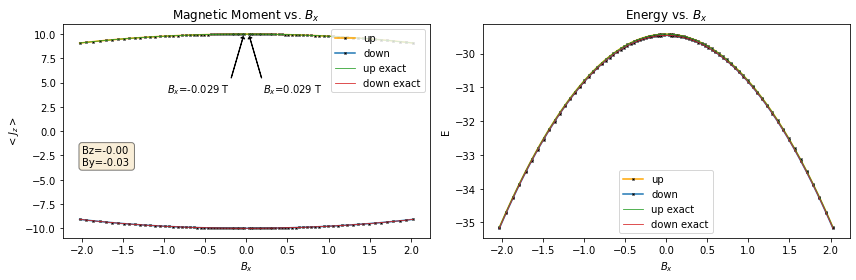

In [13]:
# find the indices of the Bz and By values closest to 1.0 and 0.0
BzIndex=(np.abs(np.array(Bz) - 0.0)).argmin()
ByIndex=(np.abs(np.array(By) - 0.0)).argmin()

# plt.plot(Bx,magnetic_moment_up_arr[(np.abs(np.array(By) - 0.0)).argmin(),ByIndex,:],label='up')
# plt.show()
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(-2.,-3.5,'Bz=%0.2f \nBy=%0.2f'%(Bz[BzIndex],By[ByIndex]), bbox=props)
plt.plot(Bx,magnetic_moment_up_arr[BzIndex,ByIndex,:],label='up',color='orange', linestyle='solid', marker='x',
     markerfacecolor='k', markeredgecolor='k', markersize=2,fillstyle='full')
plt.plot(Bx,magnetic_moment_down_arr[BzIndex,ByIndex,:], label='down',color='tab:blue', linestyle='solid', marker='x',
     markerfacecolor='k', markeredgecolor='k', markersize=2,fillstyle='full')

# create and plot exact magnetic moment results:
exact_x_arr=np.linspace(Bx[0],Bx[-1],num=801)
# format of the results is (magnetic_moment_up_arr, magnetic_moment_down_arr, energy_up_arr, energy_down_arr)
exact_res_arr=create_slice_exact_Bx_diag(exact_x_arr,By[ByIndex],Bz[BzIndex])

arrow_props=dict(facecolor='black', shrink=0.05, width=0.3, headwidth=4, headlength=2)

plt.plot(exact_x_arr,exact_res_arr[0], label='up exact', linewidth=0.8, color='tab:green')
plt.plot(exact_x_arr,exact_res_arr[1], label='down exact', linewidth=0.8, color='tab:red')
plt.annotate(r"$B_x$=0.029 T",xytext=(0.2,4),xy=(0.029,exact_res_arr[0][(np.abs(np.array(exact_x_arr) - 0.029)).argmin()]),
            arrowprops=arrow_props)
plt.annotate(r"$B_x$=-0.029 T",xytext=(-0.2,4),xy=(-0.029,exact_res_arr[0][(np.abs(np.array(exact_x_arr) - -0.029)).argmin()]),
            arrowprops=arrow_props, horizontalalignment='right')

plt.title(r'Magnetic Moment vs. $B_x$')
plt.legend(loc=1)
plt.ylabel(r'$<J_z>$')
plt.xlabel(r'$B_x$')
# plt.xlim(-1,1)
# plt.ylim(4,6)
plt.subplot(1,2,2)
plt.plot(Bx,energy_up_arr[BzIndex,ByIndex,:], label='up',color='orange', linestyle='solid', marker='x',
     markerfacecolor='k', markeredgecolor='k', markersize=2,fillstyle='full')
plt.plot(Bx,energy_down_arr[BzIndex,ByIndex,:], label='down',color='tab:blue', linestyle='solid', marker='x',
     markerfacecolor='k', markeredgecolor='k', markersize=2,fillstyle='full')

# plot exact energy results:
plt.plot(exact_x_arr,exact_res_arr[2], label='up exact', linewidth=0.8, color='tab:green')
plt.plot(exact_x_arr,exact_res_arr[3], label='down exact', linewidth=0.8, color='tab:red')
# plt.ylim(-247.5,-245)
# plt.xlim(-0.5,0.5)
plt.title(r'Energy vs. $B_x$')
plt.legend()
plt.ylabel('E')
plt.xlabel(r'$B_x$')

plt.tight_layout()
# plt.savefig('energy_and_magnetic_moment_vs_Bx.eps',format='eps')
plt.show()

ValueError: x and y must have same first dimension, but have shapes (80,) and (512000,)

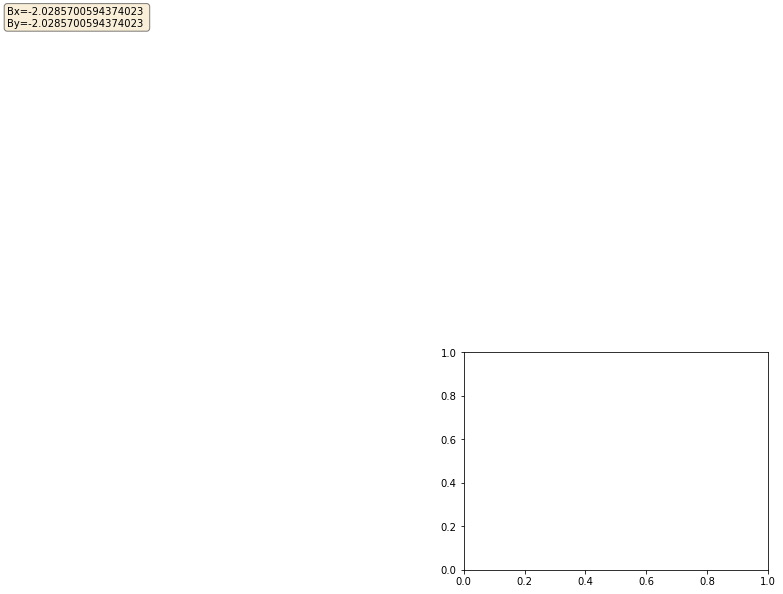

In [14]:
plt.figure(figsize=(12,4))
plt.text(0.5,0.5,'test')
plt.subplot(1,2,1)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(-1.5,+2.5,'Bx=%s \nBy=%s'%(Bx[0],By[0]), bbox=props)
plt.plot(Bz,magnetic_moment_up_arr.flatten(),label='up')
plt.plot(Bz,magnetic_moment_down_arr.flatten(), label='down')
plt.title('magnetic moment vs. Bz')
plt.legend(loc=1)
plt.ylabel(r'$<J_z>$')
plt.xlabel('Bz')
plt.subplot(1,2,2)
plt.plot(Bz,energy_up_arr.flatten(), label='up')
plt.plot(Bz,energy_down_arr.flatten(), label='down')
plt.title('energy vs. Bz')
plt.ylabel('E')
plt.xlabel('Bz')
plt.legend()

plt.tight_layout()
plt.show()

In [6]:
from matplotlib.widgets import Slider, Button, RadioButtons
# plt.close(fig)
fig, ax = plt.subplots()
plt.subplots_adjust(left=0.25, bottom=0.25)
bx=0.0
delta_bz=0.005
delta_bx=0.05
by=0.0
bz=0.05
H_zeeman = u_B*g_L*(bx*jx + by*jy + bz*jz)    # zeeman term
H = H_cf - H_zeeman # full hamiltonian
w,v = LA.eigh(H)

magnetic_moments = np.real(np.diagonal(np.conj(v.T)@jz@v))
l, = plt.plot(magnetic_moments, w,'k_')
ax.margins(x=0)

axcolor = 'lightgoldenrodyellow'
axbz = plt.axes([0.25, 0.1, 0.65, 0.03], facecolor=axcolor)
axbx = plt.axes([0.25, 0.15, 0.65, 0.03], facecolor=axcolor)

sbz = Slider(axbz, 'Bz', -.5, .5, valinit=bz, valstep=delta_bz)
sbx = Slider(axbx, 'Bx', -1.0, 1.0, valinit=bx, valstep=delta_bx)

def update(val):
    bz = sbz.val
    bx = sbx.val
    H_zeeman = u_B*g_L*(bx*jx + by*jy + bz*jz)    # zeeman term
    H = H_cf - H_zeeman # full hamiltonian
    w,v = LA.eigh(H)

    magnetic_moments = np.real(np.diagonal(np.conj(v.T)@jz@v))
    l.set_xdata(magnetic_moments)
    l.set_ydata(w)
    fig.canvas.draw_idle()


sbz.on_changed(update)
sbx.on_changed(update)

resetax = plt.axes([0.8, 0.025, 0.1, 0.04])
button = Button(resetax, 'Reset', color=axcolor, hovercolor='0.975')


def reset(event):
    sbz.reset()
    sbx.reset()
button.on_clicked(reset)

# ax.set_xlim((-6.,6.))
# ax.set_ylim((-248,-244))
ax.grid()
plt.show()

In [8]:
w,v = LA.eigh(H_cf)
w

array([-29.43822276, -29.43822276, -23.93011952, -23.93011945,
       -19.01535699, -19.01535061, -14.70110843, -14.70082257,
       -11.00511973, -10.99783389,  -8.0037338 ,  -7.90197253,
        -5.91878221,  -5.27975476,  -4.4657724 ,  -2.76045463,
        -2.6161143 ,   0.05116202,   0.06073416,   3.31336918,
         3.31359599])